#Workshop Scenario

Trying to build an activity recognition system for several workshop activities.


##Hypthesis 
We can distinguish hammering, screwdriving, sandpapering and sawing, using a wirst worne accelerometer/gyroscope
(so far user dependent).

##Data Recording

The assembly.dat file contains a recording done from a assembly session.

A person was doing the following activities: 

* hammering in nails (label 1)
* screwdring (label 2)
* sandpapering (label 3)
* sawing (label 4)

Label 0 is for doing none of the activities above. The sensor is attached to the subjects right wrist (x axis pointing towards the fingers). 
The sensor was sampled with 100 Hz, it's raw sensor data (not calibrated). The data structure of the file is shown in the header of the file.

In [3]:
from pandas import read_csv
%pylab inline

data = read_csv('./data/assembly.dat',delimiter='\t',skiprows=11,names=['s','usec','ax','ay','az','gx','gy','gz','mx','my','mz','label'])

Populating the interactive namespace from numpy and matplotlib


#Data Exploration
After we read in the data, use the describe() function to get an overview.

In [ ]:
data

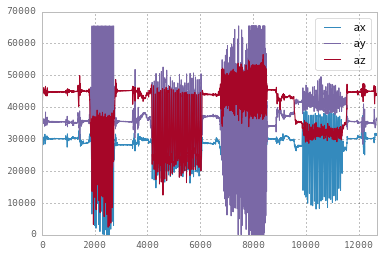

In [54]:
#to get access to a specific data column you can use the following:
data['ax']
data[['ax','ay','az']].plot()

Use describe() just on the accelerometer data.
Then use describe() on the gyro data.


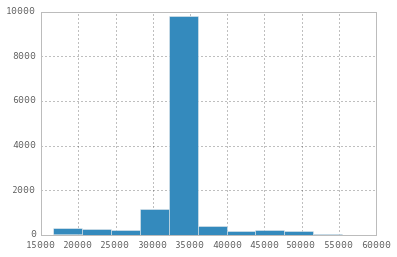

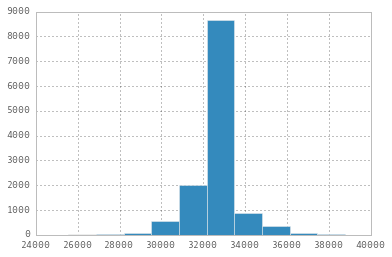

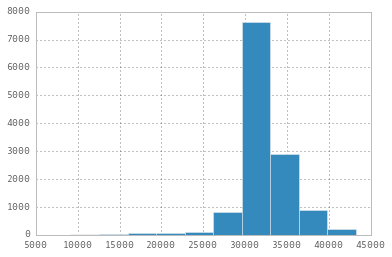

In [51]:
data['gx'].hist()


Actually that does not tell us too much. Quickly plot the accelerometer and gyro data. Can you see a difference between the acceleration and rotational velocity? What is it?

Next use the hist() function on the individual axis of the acceleration and gyroscope.

If you want to print several plots into one figure use hold(True)

In [ ]:
hold(True)
hist(data['ax'])
hist(data['ay'])

##Segmenting the individual activities
Let's look at the hammering, screwdriving, sandpapering and sawing data individually.
You can use pandas filtering on the individual labels e.g.

accel_hammer = data[data['label']==1][['ax','ay','az']]

plot them and calculate the descriptive statistics (e.g. mean, var etc.).

Do you think the activitites can be recognized using these sensors?

Can you distinguish them?


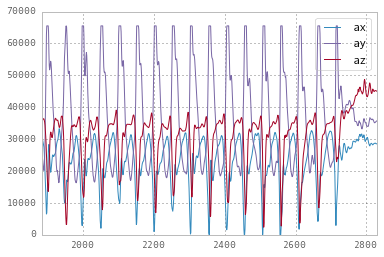

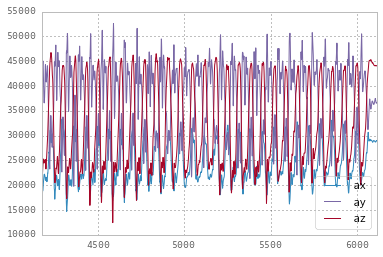

In [3]:
accel_hammer = data[data['label']==1][['ax','ay','az']]
accel_screw = data[data['label']==2][['ax','ay','az']]


accel_hammer.plot()
accel_screw.plot()



#How to deal with Time Series Data
One of the easiest ways to classify and work with Time Series Data is to use a sliding window, sometimes also called rolling function.


In [7]:
accel_hammer = data[data['label']==1][['ax','ay','az']]
from pandas.stats.moments import rolling_apply

method = var
wsize = 50

accel_var_hammer = rolling_apply(accel_hammer, wsize, method).dropna()
accel_var_screw = rolling_apply(accel_screw, wsize, method).dropna()




#Finding Features

You can use scatter() to plot the different features against each other ...
If you use hold on it can give you a hint if the data is distinguishable.

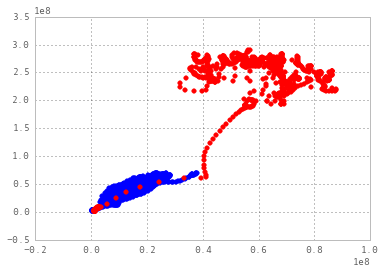

In [12]:
scatter(accel_var_screw['ax'],accel_var_screw['ay'],color='blue')
scatter(accel_var_hammer['ax'],accel_var_hammer['ay'],color='red')


#Classification#
Let's split the data into chunks according to the activities and calculate the median over a sliding window (might not be the best feature).

In [6]:
gyro_hammer = data[data['label']==1][['gx','gy','gz']]
gyro_screw = data[data['label']==2][['gx','gy','gz']]
gyro_sand = data[data['label']==3][['gx','gy','gz']]
gyro_saw = data[data['label']==4][['gx','gy','gz']]

from pandas.stats.moments import rolling_apply

method = median
wsize = 25

feat1 = rolling_apply(gyro_screw, wsize, method).dropna()
feat2 = rolling_apply(gyro_hammer,wsize, method).dropna()
feat3 = rolling_apply(gyro_sand, wsize, method).dropna()
feat4 = rolling_apply(gyro_saw, wsize, method).dropna()




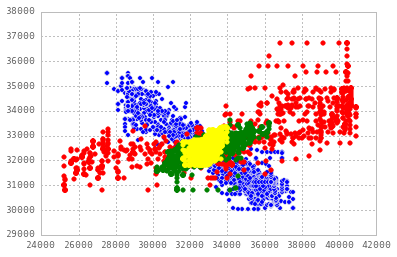

In [7]:
scatter(feat1['gz'], feat1['gy'])
scatter(feat2['gz'], feat2['gy'],color='red')
scatter(feat3['gz'], feat3['gy'],color='green')
scatter(feat4['gz'], feat4['gy'],color='yellow')

In [8]:
#don't look here ... I split the data in test and training set
#bad code :)

l_1 = len(feat1)
l_2 = len(feat2)
l_3 = len(feat3)
l_4 = len(feat4)

#X = feat1.append(feat2).append(feat3).append(feat4)
#Y = [1.0] * l_1 + [2.0]* l_2 + [3] * l_3 + [4] * l_4

X = feat1[0:l_1/2].append(feat2[0:l_2/2]).append(feat3[0:l_3/2]).append(feat4[0:l_4/2])
Y = [1]*(l_1/2) + [2]*(l_2/2)+[3]*(l_3/2) + [4]*(l_4/2)

T = feat1[l_1/2:l_1].append(feat2[l_2/2:l_2]).append(feat3[l_3/2:l_3]).append(feat4[l_4/2:l_4])
t_gg = [1]*len(feat1[l_1/2:l_1]) + [2]*len(feat2[l_2/2:l_2]) + [3]*len(feat3[l_3/2:l_3]) + [4]*len(feat1[l_4/2:l_4])

In [10]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

X contains the training data, Y the labels for the training data.
T contains the testing data, t_gg the labels for the testing data. Go ahead and train a classifier ... evaluate it.

In [12]:
#if you have trained a classifier you can use this code for crossvaildation
from sklearn.utils import shuffle
from sklearn.cross_validation import StratifiedKFold, cross_val_score

Xn, yn = shuffle(T, t_gg)
skf = StratifiedKFold(yn, 10)
print cross_val_score(dt, Xn, yn, cv=skf)

[ 0.93464052  0.93137255  0.93114754  0.9375      0.9375      0.94078947
  0.9375      0.93092105  0.88741722  0.91059603]
